In [163]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from scipy.interpolate import BSpline
# from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import ELBO, SVI, Predictive, init_to_value, MCMC, NUTS

from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

#### Common

#### 4m1


<AxesSubplot:>

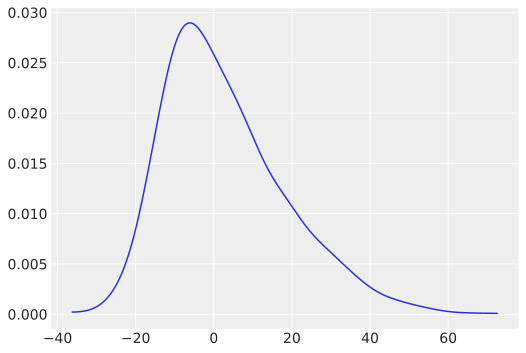

In [21]:
sample_mu = dist.Normal(0, 10).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 10).sample(random.PRNGKey(0), (int(1e4),))
prior_y = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(0))
arviz.plot_kde(prior_y)

#### 4h1

In [27]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

prior predictive distribution

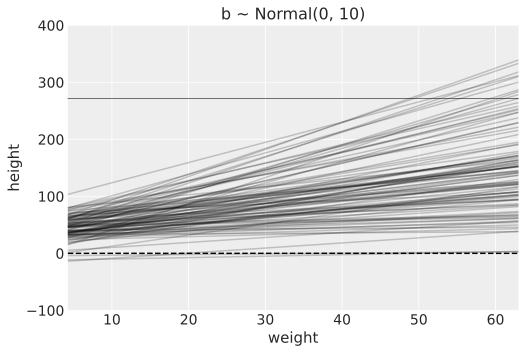

In [111]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample("a", dist.Normal(40, 20).expand([N]))
    b = numpyro.sample("b", dist.HalfNormal(2, 1).expand([N]))

plt.subplot(
    xlim=(d.weight.min(), d.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
#xbar = d.weight.mean()
x = jnp.linspace(d.weight.min(), d.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x), "k", alpha=0.2)
plt.show()

In [116]:
X_weight = jnp.array([46.95, 43.72, 64.78, 32.59, 54.63]).T

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(40, 20))
    b = numpyro.sample("b", dist.Normal(2, 1))
    mu = a + b * weight
    sigma = numpyro.sample("sigma", dist.Uniform(0, 20))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)



In [195]:
svi_args = dict(weight=d.weight.values, height=d.height.values)
init_state_size = 2000
n_pozzsterior_samples = 1000
start = {} #'a': 10., 'b': .1, 'sigma': 0.1}

guide_gen = AutoLaplaceApproximation(model, init_strategy=init_to_value(values=start))
svi = SVI(model, guide_gen, optim.Adam(1), ELBO(), **svi_args)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(init_state_size))
params = svi.get_params(state)
post_samples = guide_gen.sample_posterior(random.PRNGKey(1), params, (n_posterior_samples,))
print_summary(post_samples, 0.89, False)

TypeError: model() got an unexpected keyword argument 'weight'

In [118]:
sim_height = Predictive(guide_gen.model, post_samples, return_sites=["height"])(
    random.PRNGKey(2), X_weight, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 5), [162.56886, 161.66113, 145.20198, 159.2341, 147.3553])

In [119]:
height_expected = jnp.mean(sim_height, axis=0)
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)
height_expected, height_PI.T

(DeviceArray([158.15901, 152.6883 , 189.70775, 132.97061, 171.92036], dtype=float32),
 DeviceArray([[143.02269, 173.44757],
              [137.31056, 166.6169 ],
              [174.65714, 204.3579 ],
              [118.82662, 147.43579],
              [157.14389, 186.94424]], dtype=float32))

5m1

In [159]:
N = 100
income = dist.Normal(0, 1).sample(random.PRNGKey(0), (N,))
operas = dist.Normal(income, 2).sample(random.PRNGKey(1))
scores = dist.Normal(income, 1).sample(random.PRNGKey(2))

df_spur = pd.DataFrame({'income': list(income), 'operas': list(operas), 'scores': list(scores)})
print(df_spur.shape)
df_spur.head()

(100, 3)


,income,operas,scores
0,-1.981071,-5.644257,-3.162106
1,1.048172,0.659061,1.728182
2,0.889819,-2.489435,2.304852
3,0.035166,-2.648784,-0.704130
4,-0.947359,0.548720,0.372078


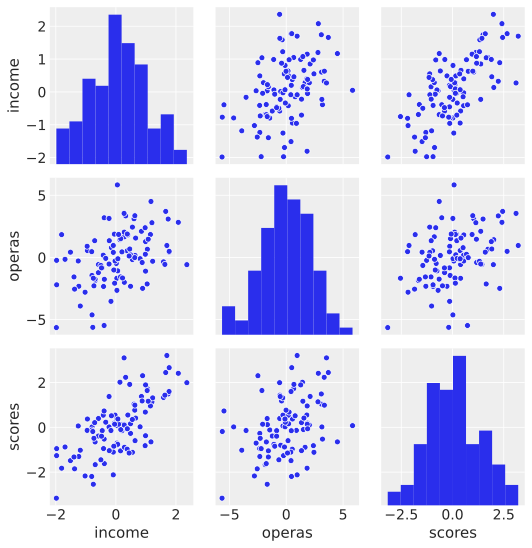

In [160]:
sns.pairplot(df_spur, x_vars=df_spur.columns, y_vars=df_spur.columns, palette='husl')

In [169]:
def model(scores, operas=None, income=None):
    a = numpyro.sample('a', dist.Normal(0., 1.))
    O, I = 0, 0
    if operas is not None:
        bO = numpyro.sample('bO', dist.Normal(0, 5))
        O = bO * operas
    if income is not None:
        bI = numpyro.sample('bI', dist.Normal(0, 5))
        I = bI * scores
    sigma = numpyro.sample('sigma', dist.Uniform(0, 5))
    mu = a + O + I

    numpyro.sample('scores', dist.Normal(mu, sigma), obs=scores)

In [171]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, scores=df_spur.scores.values, operas=df_spur.operas.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 253.64it/s, 3 steps of size 7.45e-01. acc. prob=0.93]
                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.08      0.12      0.08     -0.14      0.26   2011.81      1.00
        bO      0.21      0.06      0.21      0.11      0.30   1404.35      1.00
     sigma      1.22      0.09      1.22      1.07      1.36   1617.09      1.00

Number of divergences: 0



In [172]:
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, scores=df_spur.scores.values, income=df_spur.income.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 254.45it/s, 1023 steps of size 8.12e-08. acc. prob=0.75]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.00     -0.00     -0.00      0.00    149.25      1.00
        bI      1.00      0.00      1.00      1.00      1.00      0.50      1.00
     sigma      0.00      0.00      0.00      0.00      0.00      0.50      1.00

Number of divergences: 0


In [174]:
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, scores=df_spur.scores.values, operas=df_spur.operas.values, income=df_spur.income.values)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 301.99it/s, 3 steps of size 4.14e-05. acc. prob=0.66]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.00      0.00     -0.00      0.00   1518.92      1.00
        bI      1.00      0.00      1.00      1.00      1.00   1721.13      1.00
        bO      0.00      0.00      0.00     -0.00      0.00   2119.04      1.00
     sigma      0.00      0.00      0.00      0.00      0.00      2.53      2.59

Number of divergences: 0


5m2



In [178]:
N = 100
rho = 0.6
alcohol = dist.Normal(0, 1).sample(random.PRNGKey(0), (N,))
illness = dist.Normal(alcohol * 0.6, jnp.sqrt(1. - rho**2.)).sample(random.PRNGKey(1))
happiness = dist.Normal(alcohol - illness, 1).sample(random.PRNGKey(2))

df_mask = pd.DataFrame({'alcohol': list(alcohol), 'illness': list(illness), 'happiness': list(happiness)})
print(df_mask.shape)
df_mask.head()

(100, 3)


,alcohol,illness,happiness
0,-1.981071,-2.653917,-0.508189
1,1.048172,0.473259,1.254923
2,0.889819,-0.817810,3.122662
3,0.035166,-1.052481,0.348351
4,-0.947359,0.030016,0.342062


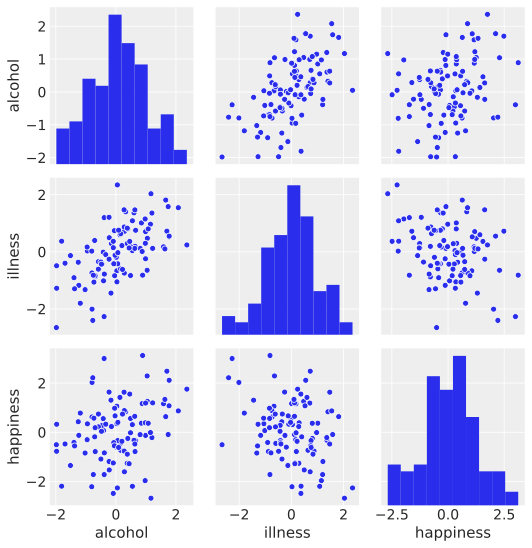

In [180]:
sns.pairplot(df_mask, palette='husl')

In [191]:
def model(happiness, alcohol=None, illness=None):
    a = numpyro.sample('a', dist.Normal(0., 1.))
    A, I = 0, 0
    if alcohol is not None:
        bA = numpyro.sample('bA', dist.Normal(0, 5))
        A = bA * alcohol
    if illness is not None:
        bI = numpyro.sample('bI', dist.Normal(0, 5))
        I = bI * illness
    sigma = numpyro.sample('sigma', dist.Uniform(0, 5))
    mu = a + A + I

    numpyro.sample('happiness', dist.Normal(mu, sigma), obs=happiness)

In [192]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, happiness=df_mask.happiness.values, alcohol=df_mask.alcohol.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 263.74it/s, 1 steps of size 8.23e-01. acc. prob=0.91]
                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.03      0.12      0.02     -0.16      0.22   1737.81      1.00
        bA      0.36      0.12      0.36      0.16      0.57   1708.50      1.00
     sigma      1.17      0.09      1.17      1.03      1.31   1917.56      1.00

Number of divergences: 0



In [193]:
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, happiness=df_mask.happiness.values, illness=df_mask.illness.values)
mcmc.print_summary()
samples_2= mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:13<00:00, 215.90it/s, 3 steps of size 8.60e-01. acc. prob=0.90]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.07      0.12      0.07     -0.14      0.25   2008.42      1.00
        bI     -0.39      0.12     -0.40     -0.62     -0.21   1886.09      1.00
     sigma      1.16      0.09      1.16      1.02      1.29   2108.69      1.00

Number of divergences: 0


In [194]:
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(
    rng_key_,
    happiness=df_mask.happiness.values,
    alcohol=df_mask.alcohol.values,
    illness=df_mask.illness.values
)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:12<00:00, 242.81it/s, 3 steps of size 5.75e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.09      0.00     -0.16      0.15   1716.13      1.00
        bA      0.88      0.12      0.89      0.70      1.09   1827.58      1.00
        bI     -0.89      0.12     -0.89     -1.08     -0.70   1910.49      1.00
     sigma      0.94      0.07      0.93      0.82      1.05   1779.33      1.00

Number of divergences: 0
